# import files/libraries

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
import io
import os
from scipy.stats import pearsonr
import itertools
import random
from random import sample 
from random import random
import time
import pickle
import seaborn as sns
import dateutil.parser
from dateutil.parser import parse
from datetime import datetime
from scipy.stats import f_oneway
import plotly.graph_objects as go

import xgboost 
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

#TF and Keras for neural net:
import tensorflow as tf
import keras
from keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.models import model_from_json


# !pip install shap
# #!pip install git+https://github.com/slundberg/shap.git
# import shap

# Functions


In [ ]:
def pct(df): # make the list differenced by pct, return the same lenght.
  lst = [0]
  for i in range(1,len(df)):
    lst.append(df[i]/df[i-1]-1)
  return lst

def stdev(df, days): # returns the stdev of past 'days' days including today.
  lst = (days-1)*[0]
  for i in range(days,len(df)+1):
    lst.append(np.std(df[i-days:i]))
  return lst

def HV(df, days): # returns the HV of past 'days' days including today.
  lst = (days-1)*[0]
  for i in range(days,len(df)+1):
    lst.append(round(100*np.std(df[i-days:i])*256**0.5,1))
  return lst
# https://www.danielstrading.com/education/technical-analysis-learning-center/historic-volatility
# https://www.fool.com/knowledge-center/how-to-calculate-annualized-volatility.aspx

def HV_modified(df, days): # returns the HV of past 'days' days including today + days are watered down.
  lst = (days-1)*[0]
  df = [x if x<0 else x/4 for x in df]
  for i in range(days,len(df)+1):
    lst.append(round(100*np.std(df[i-days:i])*21**0.5,1))
  return lst

def pct_fwd(df, days, value = 0): 
  ''' inputs price and returns the gain/loss of 'days' days forward refereneced to today.'''
  lst = []
  for i in range(len(df)-days):
    lst.append(df[i+days-1]/df[i] - 1)
  for j in range(days):
    lst.append(value)
  return lst

# inputs list of percentages and returns simulated growth of $100 
def growth(lst, start = 100):
  start = start
  growth_list = [start]
  for i in range(1,len(lst)):
    start += start*lst[i]
    growth_list.append(start)
  return growth_list

def ema(df, EMA_days):# returns the ema of past 'sma_days' days including today.
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def sma(df, sma_days):# returns the sma of past 'sma_days' days including today.
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

# returns two lists of resistance (max) and support (min) over past 'days' days including today
def sup_res(df, days): 
  maxs = [0]*(days - 1)
  mins = [0]*(days - 1)
  for i in range(days, len(df)+1): # len(df)+1 because range does not count the last int.
    mx = max(df[i-days:i])
    mn = min(df[i-days:i])
    maxs.append(mx)
    mins.append(mn)
  return maxs, mins #resistance and support

def slopes(df, days): #returns the slope of past 'days' days including today.
  slopelist = (days-1)*[0]
  for i in range(days,len(df)+1):
    slopelist.append(np.polyfit(np.asarray((range(0,days))),np.asarray(df[i-days:i]),1)[0])
  return slopelist

def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)
    plt.show()
        
#fix random effect
def fix_rnd_Keras():
    seed_value= 0
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.random.set_seed(seed_value)
    from keras import backend as K
    session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

# returns a 3D version of x (number of samples, time steps (window), features) and 2D version of y for LSTM.
# gap defines the overlap between samples, gap = 1: max overlap, gap = window: no overlap
def windower(x,y, window, gap): 
  i = 0
  data_X, data_Y = [], []
  x = np.asarray(x)
  while i in range(len(x) - window):
      data_X.append(x[i:(i + window), :])
      data_Y.append(y[i + window-1])
      i += gap
  return np.asarray(data_X), np.reshape(data_Y,(-1,1))

# return the split of test and train for LSTM: requires lenght to be divisible to batch_size for stateful LSTM
def test_train_split(x, y, batch_size, train_ratio):       
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

# One hot encoding of categorical features. 
def OHE(df):
    x = np.asarray(df)
    encoded_x = None
    for i in range(0, x.shape[1]):
      label_encoder = LabelEncoder()
      feature = label_encoder.fit_transform(x[:,i])
      feature = feature.reshape(x.shape[0], 1)
      onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
      feature = onehot_encoder.fit_transform(feature)
      if encoded_x is None:
          encoded_x = feature
      else:
              encoded_x = np.concatenate((encoded_x, feature), axis=1)
    return encoded_x

def sloper(vxx, ema_days, slope_days, l_thresh, h_thresh, mx_thresh, vvix_thresh): # returns labels based on the threshhold on the slope
  color = []
  c_label = []
  vxx['vix_slop'] = slopes(ema(vxx.vix,ema_days),slope_days)
  vxx['mx'] = maxer(vxx.vix,10)
  vxx['vvix'] = HV(pct(vxx.vix), 10)
  for i in range(len(vxx)):
    if vxx.vix_slop[i] > h_thresh:
      color.append('red')
      c_label.append(-2)
    elif vxx.vix_slop[i] < h_thresh and vxx.vix_slop[i] > l_thresh:
      color.append('orange')
      c_label.append(-1)
    elif vxx.vix_slop[i] > -l_thresh and vxx.vix_slop[i] < l_thresh:
      color.append('green')
      c_label.append(0)
    elif vxx.vix_slop[i] < -l_thresh and vxx.vix_slop[i] > -h_thresh:
      color.append('blue')
      c_label.append(1)
    else:
      color.append('purple')
      c_label.append(2)
  for i in range(len(color)):
    if color[i] == 'green' and vxx['mx'][i] > mx_thresh:
        color[i] = 'purple'
        c_label[i] = 2
    if color[i] == 'green' and vxx['vvix'][i] > vvix_thresh:
        color[i] = 'purple'
        c_label[i] = 2
  return color, c_label

def vix_status(vxx, sma_thresh, mx_thresh, vvix_thresh): #returns status of vix e.g. climbing, falling, flat, etc.
  status = [np.nan]*len(vxx)
  color = [np.nan]*len(vxx)
  vxx['vvix'] = HV(pct(vxx.vix), 10)
  for i in range(len(vxx)):
    if vxx.vix_sma_20[i] < sma_thresh and vxx.vix_sma_20[i] > -sma_thresh:
      if vxx.mx_20[i] > mx_thresh and vxx['vvix'][i]<vvix_thresh:
        status[i] = 'calm_fall'
        color[i] = 'blue'
      elif vxx.mx_20[i] < mx_thresh and vxx['vvix'][i]<vvix_thresh:
        status[i] = 'calm'
        color[i] = 'green'
      else:
        status[i] = 'yellow'
        color[i] = 'yellow'
    elif vxx.vix_sma_20[i] < -sma_thresh:
      status[i] = 'sharp_fall'
      color[i] = 'purple'
    else:
      if vxx.mx_20[i] > mx_thresh:
        status[i] = 'fall of peak'
        color[i] = 'orange'
      else:
        status[i] = 'peaking'
        color[i] = 'red'
  return status, color

def maxer(df, days): #returns the difference between max in past 'days' periods and today, in %
  maxs = [np.nan]*(days-1)
  for i in range(days, len(df)+1): # len(df)+1 because range does not count the last int.
    mx = max(df[i-days:i])
    maxs.append(mx/df[i-1]-1)
  return maxs

def accum_pct(df, days, filler): # returns sum of pct moves over past 'days' periods including today.
  pcts = [filler]*(days-1)
  for i in range(days,len(df)+1):
    pcts.append(sum(df[i-days:i]))
  return pcts

#receives df, name of column as string and threshold to return lables for the target based on threshold labeler
def target_label(vxx, column, threshold): 
  target = vxx[column]
  color = []
  label = []
  for i in range(len(target)):
    if target[i] > threshold:
      color.append('red')
      label.append(-1)
    elif target[i] > -threshold and target[i]< threshold:
      color.append('yellow')
      label.append(0)
    else:
      color.append('green')
      label.append(1)
  plt.hist(color);
  plt.show()
  plt.xlabel('Vix')
  plt.ylabel('Cont/bckwrd')
  plt.rcParams.update({'font.size': 18})
  plt.scatter(vxx.vix, vxx.cont, marker = 'o',edgecolor=color, linewidth=1.2, color = color, s = 25, alpha=0.99)
  plt.grid();
  return label, color

def labeler(target, thresh):
  label = []
  labels = []
  for i in range(len(target)):
    if target[i] > thresh:
      labels.append('long')
      label.append(0)
    elif target[i] > -thresh and target[i]< thresh:
      labels.append('cash')
      label.append(1)
    elif target[i] < -thresh:
      labels.append('short')
      label.append(2)
    else:
      labels.append(np.nan)
      label.append(np.nan)
  return label, labels

# Minute Data

- close
- talib : rsi, bollinger, 
- lower lows, higher highs, candles to signal.

In [ ]:
# upload the file into google colab
from google.colab import files
uploaded = files.upload()

In [ ]:
spx = pdr.get_data_yahoo('SPY', start= '2004-01-02', end = '2020-09-12')
spx.reset_index(inplace=True)
spx.drop('Adj Close', axis = 1, inplace=True)
spx.columns = ['date', 'high', 'low', 'open', 'close', 'volume']
spx.head(2)

,date,high,low,open,close,volume
0,2004-01-02,112.190002,110.730003,111.739998,111.230003,38072300.0
1,2004-01-05,112.519997,111.589996,111.690002,112.440002,27959800.0


In [ ]:
dt = pd.DatetimeIndex(spx.date)
start_test = '2007-10-24'
end_test = '2007-12-27'
start = dt.get_loc(start_test)
end = dt.get_loc(end_test)
spy = spx[start:end]
fig = go.Figure(data=[go.Candlestick(x=spy.date, open=spy.open, high=spy.high, low=spy.low, close=spy.close, whiskerwidth = 0.01,
                                     increasing_fillcolor= 'green',decreasing_fillcolor= 'red',
                                     increasing_line_color= 'black', decreasing_line_color= 'black',
                                     hovertext = list(df.candlestick_pattern))])
fig.update_layout( width=800, height=800, title="SPY")
fig.show();

In [ ]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

In [ ]:
candle_rankings = {
        "CDL3LINESTRIKE_Bull": 1,
        "CDL3LINESTRIKE_Bear": 2,
        "CDL3BLACKCROWS_Bull": 3,
        "CDL3BLACKCROWS_Bear": 3,
        "CDLEVENINGSTAR_Bull": 4,
        "CDLEVENINGSTAR_Bear": 4,
        "CDLTASUKIGAP_Bull": 5,
        "CDLTASUKIGAP_Bear": 5,
        "CDLINVERTEDHAMMER_Bull": 6,
        "CDLINVERTEDHAMMER_Bear": 6,
        "CDLMATCHINGLOW_Bull": 7,
        "CDLMATCHINGLOW_Bear": 7,
        "CDLABANDONEDBABY_Bull": 8,
        "CDLABANDONEDBABY_Bear": 8,
        "CDLBREAKAWAY_Bull": 10,
        "CDLBREAKAWAY_Bear": 10,
        "CDLMORNINGSTAR_Bull": 12,
        "CDLMORNINGSTAR_Bear": 12,
        "CDLPIERCING_Bull": 13,
        "CDLPIERCING_Bear": 13,
        "CDLSTICKSANDWICH_Bull": 14,
        "CDLSTICKSANDWICH_Bear": 14,
        "CDLTHRUSTING_Bull": 15,
        "CDLTHRUSTING_Bear": 15,
        "CDLINNECK_Bull": 17,
        "CDLINNECK_Bear": 17,
        "CDL3INSIDE_Bull": 20,
        "CDL3INSIDE_Bear": 56,
        "CDLHOMINGPIGEON_Bull": 21,
        "CDLHOMINGPIGEON_Bear": 21,
        "CDLDARKCLOUDCOVER_Bull": 22,
        "CDLDARKCLOUDCOVER_Bear": 22,
        "CDLIDENTICAL3CROWS_Bull": 24,
        "CDLIDENTICAL3CROWS_Bear": 24,
        "CDLMORNINGDOJISTAR_Bull": 25,
        "CDLMORNINGDOJISTAR_Bear": 25,
        "CDLXSIDEGAP3METHODS_Bull": 27,
        "CDLXSIDEGAP3METHODS_Bear": 26,
        "CDLTRISTAR_Bull": 28,
        "CDLTRISTAR_Bear": 76,
        "CDLGAPSIDESIDEWHITE_Bull": 46,
        "CDLGAPSIDESIDEWHITE_Bear": 29,
        "CDLEVENINGDOJISTAR_Bull": 30,
        "CDLEVENINGDOJISTAR_Bear": 30,
        "CDL3WHITESOLDIERS_Bull": 32,
        "CDL3WHITESOLDIERS_Bear": 32,
        "CDLONNECK_Bull": 33,
        "CDLONNECK_Bear": 33,
        "CDL3OUTSIDE_Bull": 34,
        "CDL3OUTSIDE_Bear": 39,
        "CDLRICKSHAWMAN_Bull": 35,
        "CDLRICKSHAWMAN_Bear": 35,
        "CDLSEPARATINGLINES_Bull": 36,
        "CDLSEPARATINGLINES_Bear": 40,
        "CDLLONGLEGGEDDOJI_Bull": 37,
        "CDLLONGLEGGEDDOJI_Bear": 37,
        "CDLHARAMI_Bull": 38,
        "CDLHARAMI_Bear": 72,
        "CDLLADDERBOTTOM_Bull": 41,
        "CDLLADDERBOTTOM_Bear": 41,
        "CDLCLOSINGMARUBOZU_Bull": 70,
        "CDLCLOSINGMARUBOZU_Bear": 43,
        "CDLTAKURI_Bull": 47,
        "CDLTAKURI_Bear": 47,
        "CDLDOJISTAR_Bull": 49,
        "CDLDOJISTAR_Bear": 51,
        "CDLHARAMICROSS_Bull": 50,
        "CDLHARAMICROSS_Bear": 80,
        "CDLADVANCEBLOCK_Bull": 54,
        "CDLADVANCEBLOCK_Bear": 54,
        "CDLSHOOTINGSTAR_Bull": 55,
        "CDLSHOOTINGSTAR_Bear": 55,
        "CDLMARUBOZU_Bull": 71,
        "CDLMARUBOZU_Bear": 57,
        "CDLUNIQUE3RIVER_Bull": 60,
        "CDLUNIQUE3RIVER_Bear": 60,
        "CDL2CROWS_Bull": 61,
        "CDL2CROWS_Bear": 61,
        "CDLBELTHOLD_Bull": 62,
        "CDLBELTHOLD_Bear": 63,
        "CDLHAMMER_Bull": 65,
        "CDLHAMMER_Bear": 65,
        "CDLHIGHWAVE_Bull": 67,
        "CDLHIGHWAVE_Bear": 67,
        "CDLSPINNINGTOP_Bull": 69,
        "CDLSPINNINGTOP_Bear": 73,
        "CDLUPSIDEGAP2CROWS_Bull": 74,
        "CDLUPSIDEGAP2CROWS_Bear": 74,
        "CDLGRAVESTONEDOJI_Bull": 77,
        "CDLGRAVESTONEDOJI_Bear": 77,
        "CDLHIKKAKEMOD_Bull": 82,
        "CDLHIKKAKEMOD_Bear": 81,
        "CDLHIKKAKE_Bull": 85,
        "CDLHIKKAKE_Bear": 83,
        "CDLENGULFING_Bull": 84,
        "CDLENGULFING_Bear": 91,
        "CDLMATHOLD_Bull": 86,
        "CDLMATHOLD_Bear": 86,
        "CDLHANGINGMAN_Bull": 87,
        "CDLHANGINGMAN_Bear": 87,
        "CDLRISEFALL3METHODS_Bull": 94,
        "CDLRISEFALL3METHODS_Bear": 89,
        "CDLKICKING_Bull": 96,
        "CDLKICKING_Bear": 102,
        "CDLDRAGONFLYDOJI_Bull": 98,
        "CDLDRAGONFLYDOJI_Bear": 98,
        "CDLCONCEALBABYSWALL_Bull": 101,
        "CDLCONCEALBABYSWALL_Bear": 101,
        "CDL3STARSINSOUTH_Bull": 103,
        "CDL3STARSINSOUTH_Bear": 103,
        "CDLDOJI_Bull": 104,
        "CDLDOJI_Bear": 104,
        "CDLLONGLINE_Bull": 105,
        "CDLLONGLINE_Bear": 106,
        "CDLSHORTLINE_Bull": 107
    }

In [ ]:
candle_names = talib.get_function_groups()['Pattern Recognition']
op = spy['open']
hi = spy['high']
lo = spy['low']
cl = spy['close']# create columns for each pattern
df = spy.copy(deep=True)
for candle in candle_names:
    # below is same as;
    # spy["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
    df[candle] = getattr(talib, candle)(op, hi, lo, cl)
df.head(2)

,date,high,low,open,close,volume,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
959,2007-10-24,151.740005,148.839996,151.210007,151.479996,326694200.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
960,2007-10-25,152.289993,149.880005,151.649994,151.839996,237374500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from itertools import compress
df['candlestick_pattern'] = np.nan
df['candlestick_match_count'] = np.nan
for index, row in df.iterrows():

    # no pattern found
    if len(row[candle_names]) - sum(row[candle_names] == 0) == 0:
        df.loc[index,'candlestick_pattern'] = "NO_PATTERN"
        df.loc[index, 'candlestick_match_count'] = 0
    # single pattern found
    elif len(row[candle_names]) - sum(row[candle_names] == 0) == 1:
        # bull pattern 100 or 200
        if any(row[candle_names].values > 0):
            pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bull'
            df.loc[index, 'candlestick_pattern'] = pattern
            df.loc[index, 'candlestick_match_count'] = 1
        # bear pattern -100 or -200
        else:
            pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bear'
            df.loc[index, 'candlestick_pattern'] = pattern
            df.loc[index, 'candlestick_match_count'] = 1
    # multiple patterns matched -- select best performance
    else:
        # filter out pattern names from bool list of values
        patterns = list(compress(row[candle_names].keys(), row[candle_names].values != 0))
        container = []
        for pattern in patterns:
            if row[pattern] > 0:
                container.append(pattern + '_Bull')
            else:
                container.append(pattern + '_Bear')
        rank_list = [candle_rankings[p] for p in container]
        if len(rank_list) == len(container):
            rank_index_best = rank_list.index(min(rank_list))
            df.loc[index, 'candlestick_pattern'] = container[rank_index_best]
            df.loc[index, 'candlestick_match_count'] = len(container)
# clean up candle columns
df.drop(candle_names, axis = 1, inplace = True)

In [ ]:
df.head(2)

,date,high,low,open,close,volume,candlestick_pattern,candlestick_match_count
959,2007-10-24,151.740005,148.839996,151.210007,151.479996,326694200.0,NO_PATTERN,0.0
960,2007-10-25,152.289993,149.880005,151.649994,151.839996,237374500.0,NO_PATTERN,0.0


# CandleSticks

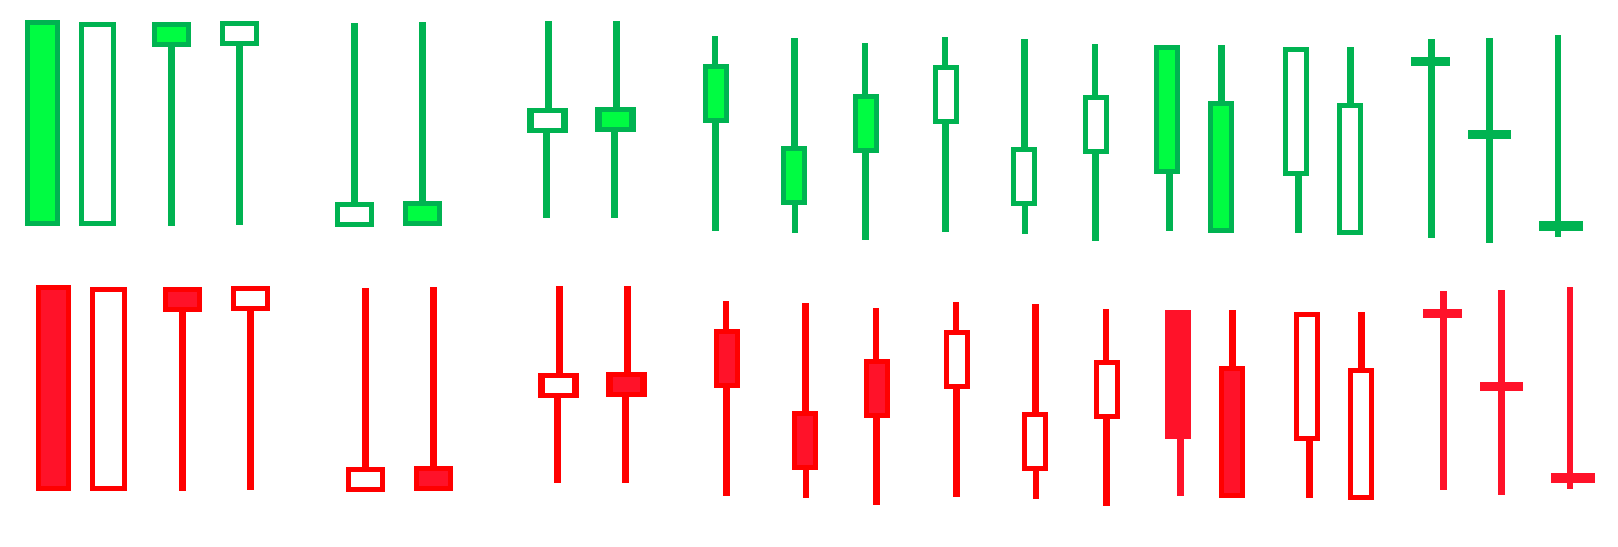

- color (red or green) and direction (filled or white) is easily definable.
- the shape is defined by three factors:

> - ratio of body to height 
> - position of middle of body to middle of height.
> - ratio of height to average of past 20 bars. 
> - filled or blank body.
> - how positioned compared to previous bar.

* if body is > 0.8 > 0.5 > 0.2  >  of height
* if mid body located in 0>0.25>0.5>0.75>1 of height.
* if height >1.5>1>0.5>0 of average past 20 bars. 
* if close > open.
* if close is in  > 1% > 0.25 > 0 > -0.25 > -1% > of previous close.

train the E matrix:
- skip gram or continuos bag of words
- a pipeline for scanning 100 stocks.


In [ ]:
def normalized_close(df, column):
  normalizeds = []
  for i in range(len(df)):
    thresh = df[column][i]
    if df.pct[i] >= thresh:
      normalizeds.append(3)
    elif df.pct[i] < thresh and df.pct[i] >= 0.3*thresh:
      normalizeds.append(2)
    elif df.pct[i] < 0.3*thresh and df.pct[i] >= 0:
      normalizeds.append(1)
    elif df.pct[i] > -0.3*thresh and df.pct[i] < 0:
      normalizeds.append(-1)
    elif df.pct[i] <= -0.3*thresh and df.pct[i] > -thresh:
      normalizeds.append(-2)
    elif df.pct[i] <= -thresh:
      normalizeds.append(-3)
  return normalizeds

def categorize(array, ratio1, ratio2):
  normalizeds = []
  for i in range(len(array)):
    if  array[i] >= ratio2:
      normalizeds.append(3)
    elif array[i] <= ratio2 and array[i] >= ratio1:
      normalizeds.append(2)
    elif array[i] <= ratio1:
      normalizeds.append(1)
  return normalizeds

def final_cats(spx):
  cats = []
  for i in range(len(spx)):
    string = str(spx.close_open[i]) + str(spx.norm_close[i]) + str(spx.catg_b_h_ratio[i]) + str(spx.catg_mid_ratio[i]) + str(spx.catg_h_ratio[i])
    cats.append(string)
  return cats

In [ ]:
spx = pdr.get_data_yahoo('SPY', start= '2004-01-02', end = '2020-09-12')
spx.reset_index(inplace=True)
spx.drop('Adj Close', axis = 1, inplace=True)
spx = spx.round(2)
spx.columns = ['date', 'high', 'low', 'open', 'close', 'volume']
spx['height'] = (spx.high - spx.low)/spx.low
spx['body'] = abs(spx.open - spx.close)/spx.low
spx['b_h_ratio'] = spx.body/spx.height
spx['mid_body'] = spx.close/2 + spx.open/2
spx['mid_ratio'] = (spx.mid_body-spx.low)/(spx.high - spx.low)
spx['sma_10_height'] = sma(spx.height, 10)
spx['height_ratio'] = spx.height/spx['sma_10_height']
spx['close_open'] = spx.close > spx.open
spx['pct'] = pct(spx.close)
spx['norm_close'] = normalized_close(spx, 'sma_10_height')
spx['catg_b_h_ratio'] = categorize(spx.b_h_ratio, 0.3, 0.7)
spx['catg_mid_ratio'] = categorize(spx.mid_ratio, 0.4, 0.6)
spx['catg_h_ratio'] = categorize(spx.height_ratio, 0.7, 1.2)
spx['candles'] = final_cats(spx)
spx = spx[10:]
spx.reset_index(inplace=True, drop=True)
print(len(np.unique(spx.candles)), 'candle types out of total possible combinations of', 3*3*3*2*6)
spx.head(3)

234 candle types out of total possible combinations of 324


,date,high,low,open,close,volume,height,body,b_h_ratio,mid_body,mid_ratio,sma_10_height,height_ratio,close_open,pct,norm_close,catg_b_h_ratio,catg_mid_ratio,catg_h_ratio,candles
0,2004-01-16,114.31,113.63,114.04,114.23,31922700.0,0.005984,0.001672,0.279412,114.135,0.742647,0.009093,0.658118,True,0.003955,2,1,3,1,True2131
1,2004-01-20,114.65,113.82,114.53,114.20,29863000.0,0.007292,0.002899,0.397590,114.365,0.656627,0.008989,0.811245,False,-0.000263,-1,2,3,2,False-1232
2,2004-01-21,115.30,113.72,114.13,115.10,30725000.0,0.013894,0.008530,0.613924,114.615,0.566456,0.009727,1.428444,True,0.007881,2,2,2,3,True2223
3,2004-01-22,115.38,114.58,115.14,114.80,29888500.0,0.006982,0.002967,0.425000,114.970,0.487500,0.009379,0.744428,False,-0.002606,-1,2,2,2,False-1222
4,2004-01-23,115.37,113.95,115.00,114.43,44245300.0,0.012462,0.005002,0.401408,114.715,0.538732,0.010058,1.239014,False,-0.003223,-2,2,2,3,False-2223


234


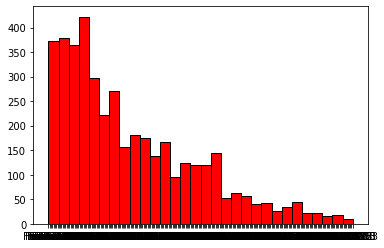

In [ ]:
print(len(np.unique(spx.candles)))
plt.hist(spx.candles,30, color = 'red', edgecolor = 'black');

In [ ]:
3*3*3*2*6

324

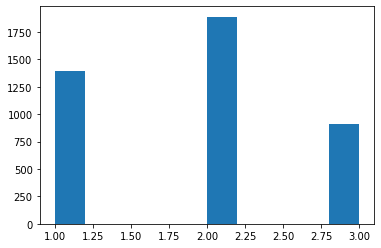

In [ ]:
plt.hist(spx.catg_b_h_ratio);

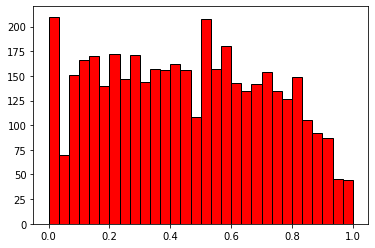

In [ ]:
plt.hist(spx.b_h_ratio, 30, color = 'red', edgecolor = 'black');

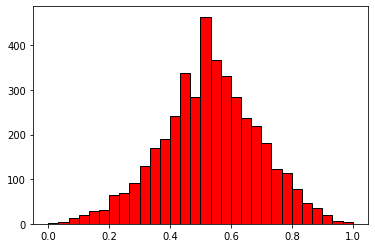

In [ ]:
plt.hist(spx.mid_ratio, 30, color = 'red', edgecolor = 'black');

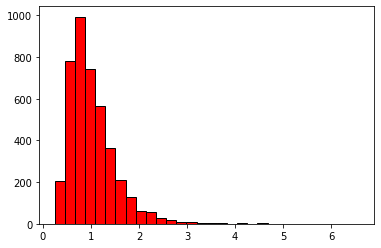

In [ ]:
plt.hist(spx.height_ratio, 30, color = 'red', edgecolor = 'black');

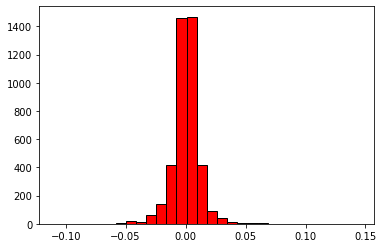

In [ ]:
plt.hist(spx.pct, 30, color = 'red', edgecolor = 'black');

### mplfinance

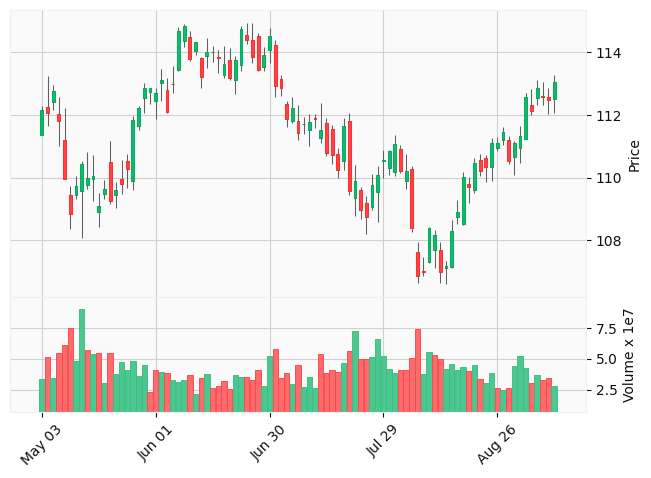

In [ ]:
pip install mplfinance
import mplfinance as mpf
import pandas as pd

df = pdr.get_data_yahoo('SPY', start= '2004-05-02', end = '2004-09-12')
mpf.plot(df, type='candle', style='yahoo', volume=True)

### Bokeh

In [ ]:
pip install bokeh

In [ ]:
import bokeh.sampledata

bokeh.sampledata.download()

In [ ]:
from math import pi

import pandas as pd

from bokeh.plotting import figure, output_file, show
from bokeh.sampledata.stocks import MSFT

df = pd.DataFrame(MSFT)[:50]
df["date"] = pd.to_datetime(df["date"])

inc = df.close > df.open
dec = df.open > df.close
w = 12*60*60*1000 # half day in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "MSFT Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.segment(df.date, df.high, df.date, df.low, color="black")
p.vbar(df.date[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df.date[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")

output_file("candlestick.html", title="candlestick.py example")

show(p) 